# BT4Py TT5 Top-1

In [71]:
%load_ext autoreload
%autoreload 2

%pwd
%cd /home/benji/Documents/Uni/heidelberg/05/masterarbeit/impls/scripts/experiments

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/benji/Documents/Uni/heidelberg/05/masterarbeit/impls/scripts/experiments


In [72]:
import polars as pl

pl.Config.set_fmt_str_lengths(300)
pl.Config.set_tbl_rows(n=50)

polars.config.Config

In [73]:
import pathlib

from scripts.common.schemas import TypeCollectionCategory
from scripts.infer.structure import DatasetFolderStructure

tool = "typilusN1"
dataset = DatasetFolderStructure(pathlib.Path(
    "/home/benji/Documents/Uni/heidelberg/05/masterarbeit/datasets/better-types-4-py-dataset"
))


In [74]:
import logging
from importlib import reload

logging.shutdown()
reload(logging)

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
for handler in logger.handlers:
    logger.removeHandler(handler)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

ch.setFormatter(logging.Formatter(f"[{tool} @ %(levelname)s]: %(message)s"))
logger.addHandler(ch)

logger.info("Hello World!")


[typilusN1 @ INFO]: Hello World!


# Loading Inference Task

In [75]:
from experiments import api

reload(api)

tasks = [
    TypeCollectionCategory.CALLABLE_PARAMETER, 
    TypeCollectionCategory.CALLABLE_RETURN, 
    TypeCollectionCategory.VARIABLE
]
inferreds = {
    task: dict(api.tasks.extended_inferreds(dataset=dataset, tool=tool, task=task))
    for task in tasks
}

for task in tasks:
    task_inferred = inferreds[task]
    assert len(task_inferred) > 0, f"Did not find any datasets for {task}!"
    logger.info(f"Found {len(task_inferred)} files for DataFrame Inference for {task}")



[typilusN1 @ INFO]: Found 50 files for DataFrame Inference for CALLABLE_PARAMETER
[typilusN1 @ INFO]: Found 50 files for DataFrame Inference for CALLABLE_RETURN
[typilusN1 @ INFO]: Found 50 files for DataFrame Inference for VARIABLE


# Loading Ground Truths

In [76]:
from experiments import api

reload(api)

ground_truths = api.tasks.extended_ground_truths(dataset=dataset)
logger.info(f"Found {len(ground_truths)} files with ground truths")

assert len(ground_truths) > 0, f"Did not find any datasets!"


[typilusN1 @ INFO]: Found 50 files with ground truths


# Ensure Datapoints line up

In [77]:
import tqdm

from scripts.infer.structure import AuthorRepo
from scripts.common.schemas import ExtendedInferredSchema, ExtendedTypeCollectionSchema
import polars as pl

pl.Config.set_tbl_width_chars(1000)

#missing_in_inferred = set(ground_truths.keys()).difference(inferreds.keys())
#missing_in_gt = set(inferreds.keys()).difference(ground_truths.keys())

#if missing_in_inferred:
#    logger.warning(f"Could not find {missing_in_inferred} in inference dataset")

#if missing_in_gt:
#    logger.warning(f"Could not find {missing_in_gt} in inference dataset")

# assert not (missing_in_inferred and missing_in_gt), f"Missing repositories!"

missing_ground_truth = list()
missing_inferred = list()

tasks_str = list(map(str, tasks))

for author_repo in tqdm.tqdm(ground_truths):
    # Select by category
    ground_truth = pl.scan_csv(source=ground_truths[author_repo], null_values=[""]).filter(
        pl.col(ExtendedInferredSchema.category).is_in(tasks_str)
    )
    inferred = pl.concat([
        pl.scan_csv(source=inferreds[task][author_repo], null_values=[""])
        for task in tasks
    ])

    gt_no_anno = ground_truth.drop(columns=ExtendedInferredSchema.anno)
    inferred_no_anno = inferred.drop(
        columns=[ExtendedInferredSchema.anno, ExtendedInferredSchema.method, ExtendedInferredSchema.topn]
    )

    missing_from_inferred = gt_no_anno.join(
        inferred_no_anno,
        on=[
            ExtendedInferredSchema.file,
            ExtendedInferredSchema.category,
            ExtendedInferredSchema.qname,
            ExtendedInferredSchema.qname_ssa,
        ],
        how="anti",
    ).with_columns(pl.lit(f"{author_repo}").alias("repository"))
    missing_from_ground_truth = inferred_no_anno.join(
        gt_no_anno,
        on=[
            ExtendedInferredSchema.file,
            ExtendedInferredSchema.category,
            ExtendedInferredSchema.qname,
            ExtendedInferredSchema.qname_ssa,
        ],
        how="anti",
    ).with_columns(pl.lit(f"{author_repo}").alias("repository"))

    missing_inferred.append(missing_from_inferred)
    missing_ground_truth.append(missing_from_ground_truth)

gt_success = True
for author_repo, missing_entries in zip(
    ground_truths,
    pl.collect_all(missing_inferred, streaming=True, common_subplan_elimination=False),
):
    gt_success = gt_success and missing_entries.is_empty()
    if not missing_entries.is_empty():
        logger.error(f"Anti-Join for Inferred Truth shows missing entries for {author_repo}")
        logger.error(f"{missing_entries}")


inf_success = True
for author_repo, missing_entries in zip(
    ground_truths,
    pl.collect_all(missing_ground_truth, streaming=True, common_subplan_elimination=False),
):
    inf_success = inf_success and missing_entries.is_empty()
    if not missing_entries.is_empty():
        logger.error(f"Anti-Join for Ground Truth shows missing entries for {author_repo}")
        logger.error(f"{missing_entries}")


assert gt_success and inf_success, "Some labels did not line up! Check the output!"


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1438.78it/s]


# Join Datapoints based on file, category and qname_ssa

In [78]:
import polars as pl

queries_for_inner = []
queries_for_missing = []
for author_repo in tqdm.tqdm(ground_truths):
    ground_truth = pl.read_csv(source=ground_truths[author_repo], null_values=[""]).filter(
        pl.col(ExtendedInferredSchema.category).is_in(tasks_str)
    ).with_columns(pl.lit(str(author_repo)).alias("repository"))
    #print(ground_truth)

    inferred = pl.concat([
        pl.read_csv(source=inferreds[task][author_repo], null_values=[""])
        for task in tasks
    ]).with_columns(pl.lit(str(author_repo)).alias("repository"))
    #print(inferred)

    
    gt_vs_inf = ground_truth.join(
        inferred,
        on=[
            "repository",
            ExtendedInferredSchema.file,
            ExtendedInferredSchema.category,
            ExtendedInferredSchema.qname,
            ExtendedInferredSchema.qname_ssa,
        ],
        how="inner",
        # validate="1:1",
        suffix=("_predict"),
    )
    #print(gt_vs_inf)
    # print(gt_vs_inf)
    queries_for_inner.append(gt_vs_inf)


for author_repo, merged, _ in zip(
    ground_truths, 
    # pl.collect_all(queries_for_inner, streaming=True, common_subplan_elimination=False),
    queries_for_inner,
    range(3)
):
    for task in tasks_str:
        task_sample = (
            merged.select([
                pl.col("repository"),
                pl.col(ExtendedInferredSchema.file),
                pl.col(ExtendedInferredSchema.category),
                pl.col(ExtendedInferredSchema.qname_ssa),
                pl.col(ExtendedInferredSchema.anno),
                pl.col("anno_predict"),
                pl.col(ExtendedInferredSchema.parametric_anno),
                pl.col("parametric_anno_predict"),
            ]).filter(pl.col(ExtendedInferredSchema.category) == task).head(n=20))
        
        logger.info(f"{task}, {task_sample}")


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 236.52it/s]
[typilusN1 @ INFO]: CALLABLE_PARAMETER, shape: (20, 8)
┌──────────────────────────┬────────────────────────────────────┬────────────────────┬──────────────────────────────────┬────────────────────────────────────────┬─────────────────────────────┬────────────────────────────────────────┬─────────────────────────┐
│ repository               ┆ file                               ┆ category           ┆ qname_ssa                        ┆ anno                                   ┆ anno_predict                ┆ parametric_anno                        ┆ parametric_anno_predict │
│ ---                      ┆ ---                                ┆ ---                ┆ ---                              ┆ ---                                    ┆ ---                    

[typilusN1 @ INFO]: VARIABLE, shape: (20, 8)
┌──────────────────────────┬────────────────────────────────────┬──────────┬──────────────────────────────┬──────┬─────────────────────────────────────────────────────────────┬─────────────────┬─────────────────────────────┐
│ repository               ┆ file                               ┆ category ┆ qname_ssa                    ┆ anno ┆ anno_predict                                                ┆ parametric_anno ┆ parametric_anno_predict     │
│ ---                      ┆ ---                                ┆ ---      ┆ ---                          ┆ ---  ┆ ---                                                         ┆ ---             ┆ ---                         │
│ str                      ┆ str                                ┆ str      ┆ str                          ┆ str  ┆ str                                                         ┆ str             ┆ str                         │
╞══════════════════════════╪═══════════════════════════

[typilusN1 @ INFO]: CALLABLE_RETURN, shape: (20, 8)
┌────────────────────────┬─────────────────────────┬─────────────────┬─────────────────────────────────────┬──────┬────────────────────────────────────────────┬─────────────────┬─────────────────────────┐
│ repository             ┆ file                    ┆ category        ┆ qname_ssa                           ┆ anno ┆ anno_predict                               ┆ parametric_anno ┆ parametric_anno_predict │
│ ---                    ┆ ---                     ┆ ---             ┆ ---                                 ┆ ---  ┆ ---                                        ┆ ---             ┆ ---                     │
│ str                    ┆ str                     ┆ str             ┆ str                                 ┆ str  ┆ str                                        ┆ str             ┆ str                     │
╞════════════════════════╪═════════════════════════╪═════════════════╪═════════════════════════════════════╪══════╪═════════════

[typilusN1 @ INFO]: CALLABLE_PARAMETER, shape: (20, 8)
┌──────────────────┬─────────────────────────┬────────────────────┬────────────────────────────────────────────┬─────────────────────────────────────────┬──────────────┬────────────────────────────┬─────────────────────────┐
│ repository       ┆ file                    ┆ category           ┆ qname_ssa                                  ┆ anno                                    ┆ anno_predict ┆ parametric_anno            ┆ parametric_anno_predict │
│ ---              ┆ ---                     ┆ ---                ┆ ---                                        ┆ ---                                     ┆ ---          ┆ ---                        ┆ ---                     │
│ str              ┆ str                     ┆ str                ┆ str                                        ┆ str                                     ┆ str          ┆ str                        ┆ str                     │
╞══════════════════╪═════════════════════════

[typilusN1 @ INFO]: VARIABLE, shape: (20, 8)
┌──────────────────┬──────────────────────────┬──────────┬────────────────────────────────────────────────────┬──────┬──────────────┬─────────────────┬─────────────────────────┐
│ repository       ┆ file                     ┆ category ┆ qname_ssa                                          ┆ anno ┆ anno_predict ┆ parametric_anno ┆ parametric_anno_predict │
│ ---              ┆ ---                      ┆ ---      ┆ ---                                                ┆ ---  ┆ ---          ┆ ---             ┆ ---                     │
│ str              ┆ str                      ┆ str      ┆ str                                                ┆ str  ┆ str          ┆ str             ┆ str                     │
╞══════════════════╪══════════════════════════╪══════════╪════════════════════════════════════════════════════╪══════╪══════════════╪═════════════════╪═════════════════════════╡
│ ocf__slackbridge ┆ slackbridge/main.py      ┆ VARIABLE ┆ BRIDGE

In [79]:
all_ground_truths_vs_predictions = pl.concat(queries_for_inner)
logger.info(f"Unprocessed sample size: {all_ground_truths_vs_predictions.shape}")
        
# Just about every publication does this: Ignore typing.Any, Any and None as it is not helpful to predict these
without_useless_annotations = all_ground_truths_vs_predictions.filter(~pl.col(ExtendedInferredSchema.anno).is_in(["typing.Any", "Any", "None"]))
logger.info(f"After removing typing.Any, Any and None from ground truth: {without_useless_annotations.shape}")
    
# Remove everything where there is no label in the ground truth dataset
no_ground_truth_label = without_useless_annotations.drop_nulls(subset=ExtendedInferredSchema.anno)
logger.info(f"After removing NULLs in ground truth annotation column: {no_ground_truth_label.shape}")

# Remove all whitespace
no_ground_truth_label = no_ground_truth_label.with_columns([
    pl.col(ExtendedInferredSchema.anno).str.replace_all(" ", ""),
    pl.col(ExtendedInferredSchema.parametric_anno).str.replace_all(" ", ""),
    pl.col("anno_predict").str.replace_all(" ", ""),
    pl.col("parametric_anno_predict").str.replace_all(" ", ""),
])
#print(no_ground_truth_label.sample(n=30))
            
# Remove trivial functions from the dataset: 'init' 'str', 'unicode', 'repr', 'len', 'doc', 'sizeof'
# adapted taken from type4py's preprocessing

# Retain everything that is not a callable or (if it is!) does not end with one of these methods
without_trivial_functions = no_ground_truth_label.filter(
    ~((pl.col(ExtendedTypeCollectionSchema.category) == str(TypeCollectionCategory.CALLABLE_RETURN)) &
    (
            pl.col(ExtendedTypeCollectionSchema.qname).str.ends_with(".__init__") |
            pl.col(ExtendedTypeCollectionSchema.qname).str.ends_with(".__str__") |
            pl.col(ExtendedTypeCollectionSchema.qname).str.ends_with(".__unicode__") |
            pl.col(ExtendedTypeCollectionSchema.qname).str.ends_with(".__repr__") |
            pl.col(ExtendedTypeCollectionSchema.qname).str.ends_with(".__len__") |
            pl.col(ExtendedTypeCollectionSchema.qname).str.ends_with(".__doc__") |
            pl.col(ExtendedTypeCollectionSchema.qname).str.ends_with(".__sizeof__")
    ))
)
logger.info(f"After removing trivially inferrable functions: {without_trivial_functions.shape}")


# Remove parameters for which it makes no sense to make predictions for (cls, self)
without_trivial_parameters = without_trivial_functions.filter(
    ~((pl.col(ExtendedTypeCollectionSchema.category) == str(TypeCollectionCategory.CALLABLE_PARAMETER)) &
    (
            pl.col(ExtendedTypeCollectionSchema.qname).str.ends_with(".cls") |
            pl.col(ExtendedTypeCollectionSchema.qname).str.ends_with(".self") |
            pl.col(ExtendedTypeCollectionSchema.qname).str.ends_with(".args") |
            pl.col(ExtendedTypeCollectionSchema.qname).str.ends_with(".kwargs")
    ))
)
logger.info(f"After removing trivially inferrable parameters: {without_trivial_parameters.shape}")


# Remove variables that are not intended to be seen anyway
without_useless_variables = without_trivial_parameters.filter(
    ~((pl.col(ExtendedTypeCollectionSchema.category) == str(TypeCollectionCategory.VARIABLE)) &
    (
        pl.col(ExtendedTypeCollectionSchema.qname).str.ends_with("._")
    ))
)
logger.info(f"After removing useless variables: {without_useless_variables.shape}")


filtered_ground_truths_vs_predictions = without_useless_variables
#logger.info(filtered_ground_truths_vs_predictions.select(
#    pl.col("repository"),
#    pl.col(ExtendedInferredSchema.file),
#    pl.col(ExtendedInferredSchema.category),
#    pl.col(ExtendedInferredSchema.qname_ssa),
#    pl.col(ExtendedInferredSchema.anno),
#    pl.col("anno_predict"),
#).sample(n=20))

# Remove TT5 artifacts
filtered_ground_truths_vs_predictions = filtered_ground_truths_vs_predictions.filter(
    pl.col("anno_predict") != "..."
)


logger.info(filtered_ground_truths_vs_predictions.select(
    pl.col("repository"),
    pl.col(ExtendedInferredSchema.file),
    pl.col(ExtendedInferredSchema.category),
    pl.col(ExtendedInferredSchema.qname_ssa),
    pl.col(ExtendedInferredSchema.anno),
    pl.col("anno_predict"),
).sample(n=20))

# Dequalify all annotations as TypeT5 did
def dequalify(annotation: str | None) -> str | None:
    import libcst
    class Dequalifier(libcst.CSTTransformer):
        def __init__(self) -> None:
            super().__init__()

        def leave_Attribute(
            self, original_node: libcst.Attribute, updated_node: libcst.Attribute
        ) -> libcst.Name:
            return updated_node.attr
    
    if annotation is None:
        return None
    return libcst.parse_module(annotation).visit(Dequalifier()).code

filtered_ground_truths_vs_predictions = filtered_ground_truths_vs_predictions.with_columns([
    pl.col(ExtendedInferredSchema.anno).apply(lambda a: dequalify(a)),
    pl.col(ExtendedInferredSchema.parametric_anno).apply(lambda a: dequalify(a)),
    pl.col("anno_predict").apply(lambda a: dequalify(a)),
    pl.col("parametric_anno_predict").apply(lambda a: dequalify(a)),
])

logger.info(filtered_ground_truths_vs_predictions.select(
    pl.col("repository"),
    pl.col(ExtendedInferredSchema.file),
    pl.col(ExtendedInferredSchema.category),
    pl.col(ExtendedInferredSchema.qname_ssa),
    pl.col(ExtendedInferredSchema.anno),
    pl.col("anno_predict"),
).sample(n=20))

[typilusN1 @ INFO]: Unprocessed sample size: (58715, 13)
[typilusN1 @ INFO]: After removing typing.Any, Any and None from ground truth: (56130, 13)
[typilusN1 @ INFO]: After removing NULLs in ground truth annotation column: (16012, 13)
[typilusN1 @ INFO]: After removing trivially inferrable functions: (15909, 13)
[typilusN1 @ INFO]: After removing trivially inferrable parameters: (15758, 13)
[typilusN1 @ INFO]: After removing useless variables: (15758, 13)
[typilusN1 @ INFO]: shape: (20, 6)
┌────────────────────────────────────────┬─────────────────────────────────────────────────────────────┬────────────────────┬─────────────────────────────────────────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────────┐
│ repository                             ┆ file                                                        ┆ categor

[typilusN1 @ INFO]: shape: (20, 6)
┌──────────────────────────────────────┬──────────────────────────────────────────────────────────┬────────────────────┬───────────────────────────────────────────────────────────┬───────────────────────────────────┬────────────────────────────────────────────────────┐
│ repository                           ┆ file                                                     ┆ category           ┆ qname_ssa                                                 ┆ anno                              ┆ anno_predict                                       │
│ ---                                  ┆ ---                                                      ┆ ---                ┆ ---                                                       ┆ ---                               ┆ ---                                                │
│ str                                  ┆ str                                                      ┆ str                ┆ str                               

In [80]:
# filtered_ground_truths_vs_predictions = filtered_ground_truths_vs_predictions.drop_nulls()

logger.info(filtered_ground_truths_vs_predictions.select(
    pl.col("repository"),
    pl.col(ExtendedInferredSchema.file),
    pl.col(ExtendedInferredSchema.category),
    pl.col(ExtendedInferredSchema.qname_ssa),
    pl.col(ExtendedInferredSchema.anno),
    pl.col("anno_predict"),
).sample(n=10))

[typilusN1 @ INFO]: shape: (10, 6)
┌──────────────────────────────────────┬────────────────────────────────────────────────────┬────────────────────┬───────────────────────────────────────────────────┬─────────────────────────┬──────────────┐
│ repository                           ┆ file                                               ┆ category           ┆ qname_ssa                                         ┆ anno                    ┆ anno_predict │
│ ---                                  ┆ ---                                                ┆ ---                ┆ ---                                               ┆ ---                     ┆ ---          │
│ str                                  ┆ str                                                ┆ str                ┆ str                                               ┆ str                     ┆ str          │
╞══════════════════════════════════════╪════════════════════════════════════════════════════╪════════════════════╪═══════════════════

In [85]:
# TypeT5 paper has Typilus evaluated ONLY on common types, as the freely trained model has no ability of predicting 
#
# The original Typilus model can predict from a set of common types as well as (nonparametric) userdefined types, 
# but their released model can only predict common types, so we only evaluate its performance on common types. - TypeT5 Paper
import libcst

from typet5.model import ModelWrapper
model = ModelWrapper.load_from_hub("MrVPlusOne/TypeT5-v7")
common_types = model.common_type_names

logger.debug(f"{len(common_types)} common types are known by TypeT5")
logger.debug(f"{common_types}")

# Rewrite to match postprocessing
rewritten = {"Dict": "dict", "Set": "set", "<List>": "list", "List": "list", "Text": "str", "Tuple": "tuple"}
common_types = {rewritten.get(ce, ce) for ce in common_types}

logger.debug(f"After rewriting, we are aware of {len(common_types)}")
logger.debug(f"{common_types}")

del model

def is_common_type(annotation: str) -> bool:
    class IsCommonVisitor(libcst.CSTVisitor):
        def __init__(self):
            super().__init__()
            self.common = True
            
        def visit_Name(self, name: libcst.Name) -> None:
            self.common = self.common and name.value in common_types
            
    visitor = IsCommonVisitor()
    libcst.parse_module(annotation).visit(visitor)
    return visitor.common

assert is_common_type("dict[int, str]")
assert not is_common_type("dict[UserDefinedType, str]")


filtered_ground_truths_vs_predictions = filtered_ground_truths_vs_predictions.with_columns(
    pl.col(ExtendedTypeCollectionSchema.anno).apply(lambda a: is_common_type(a)).alias("is_common_type")
)
filtered_ground_truths_vs_predictions = filtered_ground_truths_vs_predictions.filter(
    pl.col("is_common_type")
)
logger.info(filtered_ground_truths_vs_predictions.shape)
logger.info(filtered_ground_truths_vs_predictions.select(
    pl.col("repository"),
    pl.col(ExtendedInferredSchema.file),
    pl.col(ExtendedInferredSchema.category),
    pl.col(ExtendedInferredSchema.qname_ssa),
    pl.col(ExtendedInferredSchema.anno),
    pl.col("anno_predict"),
).sample(n=20))

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

[typilusN1 @ DEBUG]: 100 common types are known by TypeT5
[typilusN1 @ DEBUG]: {'Union', 'Issue', 'UserID', 'CWLObjectType', 'Table', 'URL', 'Field', '_T', 'Set', 'Mapping', 'Scope', 'DataFrame', 'Response', 'Flask', 'type', 'Session', 'Result', 'Namespace', 'UserContext', 'Settings', 'Model', 'Name', 'ID', 'Tuple', 'Qubit', 'BlockHeaderAPI', 'Sequence', 'Config', 'timedelta', 'bool', 'datetime', 'Task', 'Exception', 'Tensor', 'Redis', 'MagicMock', 'ArgumentParser', 'Expr', 'str', 'State', 'Decimal', 'User', 'Variable', 'bytes', 'date', 'Message', 'Parameter', 'Dict', 'Address', 'Application', 'Root', 'List', 'GlobalState', 'object', 'Configuration', 'Source', 'Callable', 'Outcome', 'BaseException', 'T', 'Text', 'Any', 'Client', 'Token', 'Vertex', '_MakeClient', 'Item', 'Event', 'BytesIO', 'Module', 'Generator', 'AsyncIterator', 'int', 'DataT', 'Logger', 'Literal', 'Context', 'IO', 'Path', 'Article', 'PartyID', 'Request', 'Iterable', 'Mock', 'Nvim', 'ndarray', 'Iterator', 'None', 'Coll

#  Prediction Metrics for Full Accuracy

In [87]:
def typet5_metrics(filtered: pl.DataFrame, column: str, simple_complex: str | None) -> None:
    if not simple_complex:
        groundtruth_labels = filtered[column].to_numpy()
        #logger.debug(groundtruth_labels.shape)

        model_predictions = filtered[f"{column}_predict"].to_numpy()
        #logger.debug(model_predictions.shape)
        
    elif simple_complex == "simple":
        simple_rows = filtered.filter(pl.col(ExtendedInferredSchema.simple_or_complex) == "simple")
        groundtruth_labels = simple_rows[column].to_numpy()
        #logger.debug(groundtruth_labels.shape)

        model_predictions = simple_rows[f"{column}_predict"].to_numpy()
        #logger.debug(model_predictions.shape)
        
    elif simple_complex == "complex":
        simple_rows = filtered.filter(pl.col(ExtendedInferredSchema.simple_or_complex) == "complex")
        groundtruth_labels = simple_rows[column].to_numpy()
        #logger.debug(groundtruth_labels.shape)

        model_predictions = simple_rows[f"{column}_predict"].to_numpy()
        #logger.debug(model_predictions.shape)
        
    else:
        assert False, f"Unknown option: {simple_complex}"
        
    logger.info(f"Evaluating on {groundtruth_labels.shape} with {simple_complex or 'all'} types")

    all_labels = np.concatenate((groundtruth_labels, model_predictions), axis=0)
    #logger.debug(all_labels.shape)

    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(all_labels)
    #logger.debug(label_encoder.classes_.shape)

    ground_truth_ids = label_encoder.transform(groundtruth_labels)
    prediction_ids = label_encoder.transform(model_predictions)

    accuracy = metrics.accuracy_score(y_true=ground_truth_ids, y_pred=prediction_ids)
    logger.info(f"{accuracy=}")

    recall = metrics.recall_score(y_true=ground_truth_ids, y_pred=prediction_ids, average="macro", zero_division=0)
    logger.info(f"{recall=}")

    precision = metrics.precision_score(y_true=ground_truth_ids, y_pred=prediction_ids, average="macro", zero_division=0)
    logger.info(f"{precision=}")

    f1score = metrics.f1_score(y_true=ground_truth_ids, y_pred=prediction_ids, average="macro", zero_division=0)
    logger.info(f"{f1score=}")
    
    

In [88]:
from sklearn import metrics, preprocessing
import numpy as np

logger.info(f"Computing metrics on {len(filtered_ground_truths_vs_predictions)} samples")


logger.info("=== Adjusted Accuracy on All (Common) Types ===")
typet5_metrics(filtered_ground_truths_vs_predictions, column=ExtendedInferredSchema.anno, simple_complex=None)

logger.info("=== Adjusted Accuracy on Simple (Common) Types ===")
typet5_metrics(filtered_ground_truths_vs_predictions, column=ExtendedInferredSchema.anno, simple_complex="simple")

logger.info("=== Adjusted Accuracy on Complex (Common) Types ===")
typet5_metrics(filtered_ground_truths_vs_predictions, column=ExtendedInferredSchema.anno, simple_complex="complex")


[typilusN1 @ INFO]: Computing metrics on 2255 samples
[typilusN1 @ INFO]: === Adjusted Accuracy on All (Common) Types ===
[typilusN1 @ INFO]: Evaluating on (2255,) with all types
[typilusN1 @ INFO]: accuracy=0.43680709534368073
[typilusN1 @ INFO]: recall=0.02825601330321337
[typilusN1 @ INFO]: precision=0.02997633191655987
[typilusN1 @ INFO]: f1score=0.027229385790444566
[typilusN1 @ INFO]: === Adjusted Accuracy on Simple (Common) Types ===
[typilusN1 @ INFO]: Evaluating on (1497,) with simple types
[typilusN1 @ INFO]: accuracy=0.6265865063460254
[typilusN1 @ INFO]: recall=0.06826286310104841
[typilusN1 @ INFO]: precision=0.09397376918603845
[typilusN1 @ INFO]: f1score=0.07406552968455277
[typilusN1 @ INFO]: === Adjusted Accuracy on Complex (Common) Types ===
[typilusN1 @ INFO]: Evaluating on (758,) with complex types
[typilusN1 @ INFO]: accuracy=0.06200527704485488
[typilusN1 @ INFO]: recall=0.00941738678710041
[typilusN1 @ INFO]: precision=0.010618954831582818
[typilusN1 @ INFO]: f1s

In [89]:
from sklearn import metrics, preprocessing
import numpy as np

logger.info(f"Computing metrics on {len(filtered_ground_truths_vs_predictions)} samples")


logger.info("=== Base Accuracy on All (Common) Types ===")
typet5_metrics(filtered_ground_truths_vs_predictions, column=ExtendedInferredSchema.parametric_anno, simple_complex=None)


[typilusN1 @ INFO]: Computing metrics on 2255 samples
[typilusN1 @ INFO]: === Base Accuracy on All (Common) Types ===
[typilusN1 @ INFO]: Evaluating on (2255,) with all types
[typilusN1 @ INFO]: accuracy=0.5419068736141907
[typilusN1 @ INFO]: recall=0.07039791999590815
[typilusN1 @ INFO]: precision=0.08136555726350096
[typilusN1 @ INFO]: f1score=0.07072206965561224


In [53]:
from sklearn import metrics, preprocessing

builtin_types = np.unique(filtered_ground_truths_vs_predictions.filter(
    pl.col(ExtendedInferredSchema.parametric_anno).str.starts_with("builtins.")
).get_column(ExtendedInferredSchema.parametric_anno).to_numpy())
print(builtin_types)
display = metrics.ConfusionMatrixDisplay.from_predictions(y_true=groundtruth_labels, y_pred=model_predictions, labels=builtin_types, normalize="true")

[]


ValueError: 'labels' should contains at least one label.

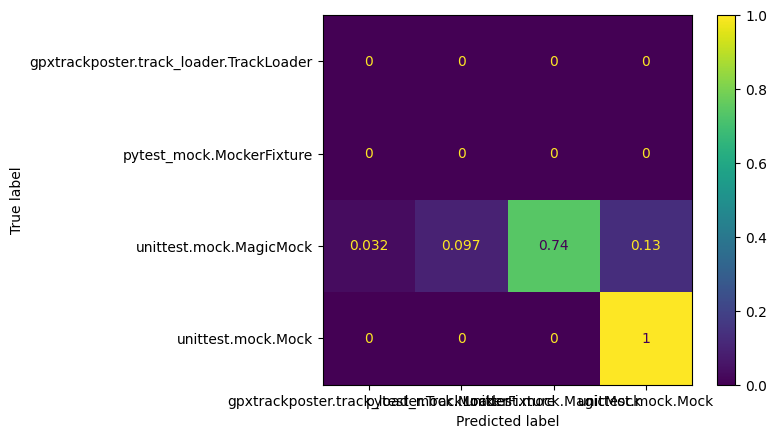

In [14]:
mock_mistakes = filtered_ground_truths_vs_predictions.select(pl.all()).filter(pl.col(ExtendedInferredSchema.parametric_anno).str.ends_with("Mock"))
#print(mock_mistakes.select(
#    pl.col("repository"),
#    pl.col(ExtendedInferredSchema.file),
#    pl.col(ExtendedInferredSchema.qname_ssa),
#    pl.col(ExtendedInferredSchema.parametric_anno),
#    pl.col("parametric_anno_predict"),
#))

groundtruth_labels = mock_mistakes.get_column(ExtendedInferredSchema.parametric_anno).to_numpy()
model_predictions = mock_mistakes.get_column("parametric_anno_predict").to_numpy()


display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true=groundtruth_labels, 
    y_pred=model_predictions, 
    labels=np.unique(np.concatenate((groundtruth_labels, model_predictions))), 
    normalize="true"
)

In [ ]:
#  Prediction Metrics for Full Accuracy